# **Problem Statement**

E-commerce platforms receive millions of customer reviews that contain valuable feedback about products and services. However, manually analyzing such a large volume of unstructured text data to understand customer sentiment and key complaint themes is not scalable.

The objective of this project is to build an NLP-based system that can:

* Automatically classify Amazon customer reviews into positive and negative sentiment

* Extract and analyze common themes present in customer feedback

* Provide actionable insights that can help businesses improve product quality and customer experience

This project focuses on applying Natural Language Processing (NLP) and Machine Learning techniques on real-world, large-scale review data.

# **Dataset Description**
1. Dataset Name

Amazon Reviews for Sentiment Analysis (fastText format)

2. Source

Kaggle - Amazon Customer Reviews Dataset
(Originally prepared for training fastText sentiment classifiers)

3. Dataset Overview
This dataset contains a few million Amazon customer reviews along with their corresponding sentiment labels derived from star ratings.

The dataset is designed to be:

* Large-scale (real business data)

* Efficient to train on a standard laptop

* Suitable for text classification and NLP experimentation

4. Data Format

Each row in the dataset follows this structure:

**__label__x review_text**

Label Meaning:

* __label__1 → Negative sentiment (1-star and 2-star reviews)

* __label__2 → Positive sentiment (4-star and 5-star reviews)

* Neutral reviews (3-star) are not included in this dataset.

# **Data Loading & Initial EDA**

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_colwidth', 300)



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train_path = "/content/drive/MyDrive/train.ft.txt"
test_path = "/content/drive/MyDrive/test.ft.txt"



In [10]:
def load_fasttext_data(file_path):
    texts = []
    labels = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()

            if line.startswith('__label__1'):
                labels.append(0)  # Negative
                texts.append(line.replace('__label__1', '').strip())
            elif line.startswith('__label__2'):
                labels.append(1)  # Positive
                texts.append(line.replace('__label__2', '').strip())

    return pd.DataFrame({
        'review_text': texts,
        'sentiment': labels
    })


In [11]:
train_df = load_fasttext_data(train_path)
test_df = load_fasttext_data(test_path)

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (3600000, 2)
Test Shape: (400000, 2)


In [12]:
train_df = train_df.sample(n=150000, random_state=42)
test_df = test_df.sample(n=30000, random_state=42)

train_df.shape, test_df.shape

((150000, 2), (30000, 2))

In [13]:
train_df.head()

,review_text,sentiment
2079998,"Expensive Junk: This product consists of a piece of thin flexible insulating material, adhesive backed velcro and white electrical tape.Problems:1. Instructions are three pictures with little more information.2. Velcro was all crumpled as received and was stronger than the adhesive. When i tried...",0
1443106,"Toast too dark: Even on the lowest setting, the toast is too dark for my liking. Also, the on light stays lit so you have to unplug it to avoid wasting electricity. Not the quality I expected from Cuisinart.",0
3463669,Excellent imagery...dumbed down story: I enjoyed this disc. The video is stunning. I agree with others that the story is very dumbed down and takes a childish approach. It actually seems like its a little one sided and VERY pro-environmental. Nevertheless its enjoyable. I would say however that ...,1
2914699,"Are we pretending everyone is married?: The authors pretend that parents neither die nor divorce. Insisting the marriage is the rock upon which all else (behavior, well-being of the child) is built, they send a clear message to non-traditional households: this book is for people who play the gam...",0
1603231,"Not worth your time: Might as well just use a knife, this product holds next to nothing. I found it to be a useless product.",0


In [14]:
test_df.head()

,review_text,sentiment
23218,"This is a great book: I must preface this by saying that I am not religious - but I loved this book. I really enjoyed the story it was telling. To me this is more a story about where we come from as women, rather than some religious/biblical treatise. Reading this book you can really feel a conn...",1
20731,"Huge Disappointment.: As a big time, long term Trevanian fan, I was extremely disappointed in this ""experiment"" by the author. I deem this effort an experiment since it is so unlike anything ""Trev"" (as his fans call him) has ever written before. Plain flat-out boring! It's almost as if Jane Aust...",0
39555,Wayne is tight but cant hang with Turk.: This album is hot as it wants to be. However Cash Moneys best album ever is Turks Young and Thuggin. So better luck next time Wayne,1
147506,"Excellent: I read this book when I was in elementary school- probably fourth grade. I read a lot of books, but this one stuck with me and I still consider it to be one of my favorites. I just recently remembered the title (after seeing crows out my window) and may have to buy myself a copy.",1
314215,"Not about Anusara: Although this book is touted on several Anusara web sites as a book about Anusara, I found it to be more about self-loathing and a poor body image. From cover to cover, the author rehashed her, and other's, disfunctions and poor self-esteem related to a poor body image and eat...",0


In [15]:
# sentiment distribution
train_df['sentiment'].value_counts()

,count
sentiment,
1,75031
0,74969


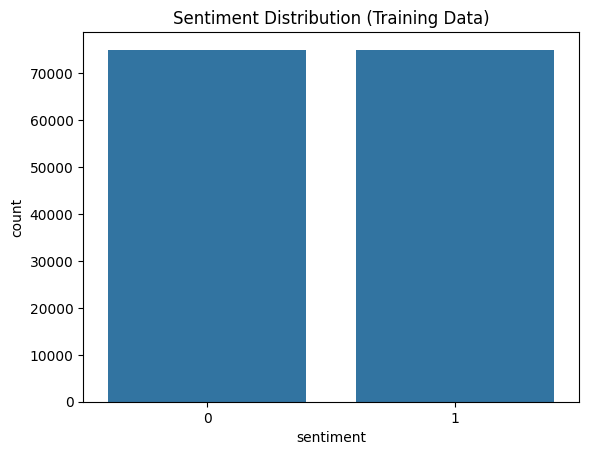

In [16]:
sns.countplot(x='sentiment', data=train_df)
plt.title("Sentiment Distribution (Training Data)")
plt.show()

The training dataset has an equal number of positive and negative sentiment labels. This balance helps ensure fair and unbiased model learning.

In [17]:
# Review length
train_df['review_length'] = train_df['review_text'].apply(len)
train_df['review_length'].describe()

,review_length
count,150000.000000
mean,431.599427
std,237.673722
min,101.000000
25%,231.000000
50%,382.000000
75%,596.000000
max,1015.000000


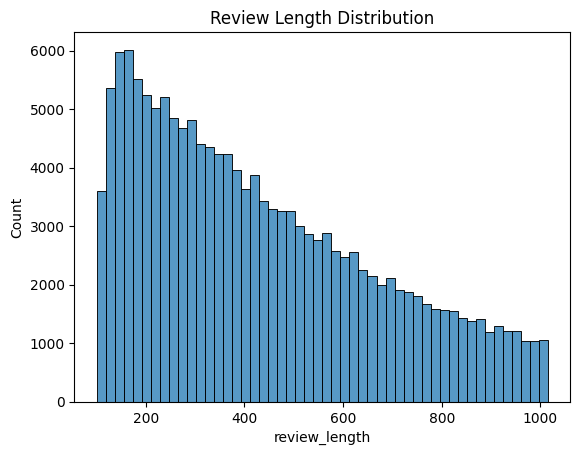

In [18]:
sns.histplot(train_df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.show()

The average Amazon review length is around 432 characters, with a wide range from 72 to 1,015. This suggests reviews vary significantly in detail, which may influence model performance and feature extraction strategies.

In [19]:
# sample reviews
# Positive reviews
train_df[train_df['sentiment'] == 1]['review_text'].sample(3, random_state=42)

,review_text
1989834,"It Works Great!: I purchased this mouse about a month ago and as it says in the description ""just plug and play."" I wasn't too happy with the bluetooth mouse I was using and it started to go out once in a while, so I decided to try a wire mouse and decided on this one. It is more comfortable tha..."
72844,"Couldn't Bear Winter without It: Wonderful, as usual! My all timne favorite is ""Soup"". I wonder who likes it better, my 3 kids or me!!!"
2815847,"Russo novels seldom disappoint: The rogues, tricksters, mentally-ill, gamblers, alcoholics and ne'er-do-wells in Risk Pool are nothing less than adorable. Russo writes beautiful prose that pulls at every one of the reader's emotions. Here, he creates a cast of loafers with a dry humor that will ..."


In [20]:
# Negative reviews
train_df[train_df['sentiment'] == 0]['review_text'].sample(3, random_state=42)

,review_text
1574675,"Disgusting: The book has obvious agendas, and trying to make these work the author sacrifices the story to them. Obviously, Robin Cook has a beef with the beef industry and the managed care systems. While his criticisms may be valid, they are so overblown that the reader is initially scared sill..."
2276056,PU: A very perfumey product and doesn't work on my fine curly hair. It's too heavy and stiff. I used it during the summer when my hair is curlier so I know it won't work in the winter.
2411035,"poor quality: the movie ""THE BURN BED"" is a excellent movie. it is a tear jerkier. the movie came out in 1980's and the film looks that old when watching the movie, sad. i still watched the movie because, it is such a good movie. the cover of the VHS is newer then the picture of the movie. the c..."


# **Text Preprocessing**

In [21]:
# Import NLP libraries
import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [22]:
# Download Required NLTK Resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
# Initialize Stopwords & Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [24]:
# Text Preprocessing Function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

In [25]:
train_df['clean_review'] = train_df['review_text'].apply(preprocess_text)
test_df['clean_review'] = test_df['review_text'].apply(preprocess_text)

In [26]:
comparison_df = train_df[['review_text', 'clean_review']].sample(5, random_state=42)
comparison_df

,review_text,clean_review
3298898,"Good tool: great tool works great, gets the job done with a durable body, very light weight too for those tight jobs",good tool great tool work great get job done durable body light weight tight job
844475,"Level 3 Pilates DVD: I love the different exercises but she goes to fast in first 3 min of the warm up then slower in the new stuff so you are waiting on her, Yes, I am glad I bought it and I do have Level 1&2. I think as I learn this new routine I will know what is coming next and be able to st...",level pilate dvd love different exercise go fast first min warm slower new stuff waiting yes glad bought level think learn new routine know coming next able start without waiting
410583,"Don't waste your money: This is a terrible book. It is a hodge-podge of different methods of estimation of the time since death compiled by european professors... The methods described are useless, and highlight that this is an art, rather than a science. For example, the incredible number of no...",dont waste money terrible book hodgepodge different method estimation time since death compiled european professor method described useless highlight art rather science example incredible number nomogram attempting describe sort condition body may found emphasize judgement experience ultimate de...
2486335,"Cut up too badly!!: I saw this movie on tv years ago and even though I had to sit through the commercials, the film was shown in in full. Not cut to pieces like this VHS version. This movie should be released on a double DVD version so as to not cut all the meaning out of it. Betty Davis would r...",cut badly saw movie tv year ago even though sit commercial film shown full cut piece like vhs version movie released double dvd version cut meaning betty davis would roll grave saw version movie
3406352,Very Good!: I have always been a big fan of John Grisham's books especially the audio books. I enjoyed the story and its pace. The Italian aspect of the story was marvelous. As fans of Mr. Grisham he keeps the story telling from becoming routine and stale. I enjoy the fact that he did incorporat...,good always big fan john grishams book especially audio book enjoyed story pace italian aspect story marvelous fan mr grisham keep story telling becoming routine stale enjoy fact incorporate type international unpredictable story character complex given depth sadly lacking today author thank sus...


Text preprocessing successfully removed noise such as punctuation, special characters, and stopwords while preserving meaningful words. The cleaned reviews are more consistent and suitable for feature extraction and sentiment analysis.

In [27]:
train_df = train_df[train_df['clean_review'].str.strip() != ""]
test_df = test_df[test_df['clean_review'].str.strip() != ""]

print("Train shape after cleaning:", train_df.shape)
print("Test shape after cleaning:", test_df.shape)

Train shape after cleaning: (150000, 4)
Test shape after cleaning: (30000, 3)


After preprocessing, the training dataset contains approximately 3.6 million reviews and the test dataset contains 400,000 reviews, indicating minimal data loss. This confirms that the cleaning pipeline is effective and scalable for large datasets.

In [28]:
# Clean Review Length
train_df['clean_review_length'] = train_df['clean_review'].apply(len)
train_df['clean_review_length'].describe()

,clean_review_length
count,150000.000000
mean,268.572093
std,150.853428
min,17.000000
25%,143.000000
50%,236.000000
75%,370.000000
max,916.000000


The average cleaned review length is approximately 269 characters, showing that significant textual information is retained after preprocessing. This balanced length distribution is ideal for TF-IDF vectorization and machine learning models.

In [29]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,      # controls feature size
    ngram_range=(1, 2),      # unigrams + bigrams
    min_df=5,                # ignore very rare words
    max_df=0.9               # ignore extremely common words
)

In [30]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_review'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_review'])

y_train = train_df['sentiment']
y_test = test_df['sentiment']

In [31]:
X_train_tfidf.shape, X_test_tfidf.shape

((150000, 20000), (30000, 20000))

The TF-IDF vectorization generated a feature matrix of shape (150,000, 20,000) for training data and (30,000, 20,000) for test data. This indicates that each review is represented using the top 20,000 most informative terms, providing a rich yet controlled feature space.

In [32]:
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names[:20]

array(['aa', 'aa battery', 'aaa', 'aaron', 'ab', 'abandon', 'abandoned',
       'abbey', 'abc', 'ability', 'able', 'able enjoy', 'able find',
       'able get', 'able hear', 'able listen', 'able make', 'able play',
       'able put', 'able read'], dtype=object)

The extracted feature names include both unigrams and meaningful bigrams, capturing important contextual information from customer reviews. This helps the model learn not just individual words but also relevant word combinations associated with sentiment.

In [33]:
X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])

0.0018684543333333332

The sparsity value of approximately 0.19% confirms that the TF-IDF matrix is highly sparse, meaning only a small number of features are active per review. This sparsity improves computational efficiency and reduces memory usage during model training.

# **Sentiment Classification using ML Models**

* Logistic Regression and Naive Bayes were selected due to their proven effectiveness in high-dimensional sparse text data and strong interpretability.


In [34]:
# import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000)

# Train model
lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

In [36]:
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     14981
           1       0.89      0.90      0.90     15019

    accuracy                           0.90     30000
   macro avg       0.90      0.90      0.90     30000
weighted avg       0.90      0.90      0.90     30000



Logistic Regression achieved strong and balanced performance with an F1-score of 0.90 for both positive and negative classes. The high precision and recall indicate that the model effectively captures sentiment patterns from TF-IDF features.

In [37]:
# Initialize Naive Bayes
nb_model = MultinomialNB()

# Train model
nb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

In [38]:
print("Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14981
           1       0.87      0.87      0.87     15019

    accuracy                           0.87     30000
   macro avg       0.87      0.87      0.87     30000
weighted avg       0.87      0.87      0.87     30000



Naive Bayes achieved an F1-score of 0.87, demonstrating good performance on large-scale text data. While slightly lower than Logistic Regression, it remains efficient and suitable for fast sentiment classification tasks

# Model Comparison & Selection
Logistic Regression outperformed Naive Bayes across all evaluation metrics, particularly in precision and recall. Therefore, Logistic Regression is selected as the final model for sentiment classification in this project.

# **Topic Modeling on Negative Reviews**

In [39]:
negative_reviews = train_df[train_df['sentiment'] == 0]['clean_review']

negative_reviews.shape

(74969,)

A total of 74,969 negative reviews were identified and used for topic modeling. This provides a sufficiently large sample to uncover recurring complaint patterns and ensure reliable topic extraction.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.9
)

In [41]:
negative_dtm = count_vectorizer.fit_transform(negative_reviews)

negative_dtm.shape

(74969, 10000)

he document–term matrix for negative reviews has a shape of (74,969 × 10,000), indicating that each review is represented using the top 10,000 most frequent terms. This controlled vocabulary balances topic interpretability and computational efficiency.

In [42]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(
    n_components=5,        # number of topics
    random_state=42,
    learning_method='batch'
)

lda_model.fit(negative_dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [43]:
def display_topics(model, feature_names, num_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

feature_names = count_vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names)



Topic 1:
movie, like, one, cd, good, song, album, film, dont, music

Topic 2:
work, product, would, one, get, use, quality, like, good, phone

Topic 3:
one, time, product, use, work, would, month, get, year, bought

Topic 4:
book, read, one, story, would, like, character, author, time, good

Topic 5:
game, product, would, money, one, amazon, dont, buy, get, item


LDA topic modeling revealed multiple recurring complaint themes:

Topic 1: Media-related dissatisfaction (movies, music, albums)

Topic 2 & 3: Product usability, quality, and durability issues

Topic 4: Book and content-related dissatisfaction

Topic 5: Purchase value, pricing, and buying experience concerns

# **Overall Business Insight**
Topic modeling shows that negative sentiment is primarily driven by product quality issues, usability problems, content expectations, and perceived value for money. These insights can help businesses prioritize product improvements and enhance customer satisfaction.

## Conclusion

This project demonstrated an end-to-end NLP pipeline on large-scale Amazon customer reviews.
TF-IDF based Logistic Regression achieved strong sentiment classification performance,
while LDA topic modeling revealed key drivers of negative customer feedback such as
product quality, usability issues, content dissatisfaction, and value-for-money concerns.

The insights derived from this analysis can support data-driven improvements in
product development, quality control, and customer experience.
